# <center> [Продвинутые фишки PyTorch Lightning 🏋️‍♀️](https://stepik.org/lesson/1500765?unit=1520879)

### Оглавление ноутбука
<img src='https://i.imgur.com/9M0zhne.jpeg' align="right" width="500" height="328" >
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🍡 Собираем базовый pipeline!</a></li>
<li>
        <a href="#c33">Фишки, связанные с обучением сетки 🌐</a>
        <ul class="sublist">
            <li><a href="#qstart">🎁 Компиляция модели </a></li>
            <li><a href="#c6">🎲 N-bit Precision</a>
            <li><a href="#c41"> Gradient accumulation 🔋</a>
            <li><a href="#c51"> Gradi
            ent clipping 🎬  </a>
        </ul>
    </li>
<li>
        <a href="#c33">Фишки, связанные с инференсом 🏎</a>
        <ul class="sublist">
            <li><a href="#qstart">🔥 ONNX </a></li>
            <li><a href="#c6">TorchScript 🧨</a>
            <li><a href="#c41">Quantization 🧩</a>
        </ul>
    </li>
<li><a href="#p6">🧸 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

<div class="alert alert-success">

В этом ноутбуке мы разберем дополнительные фишки `Lightning`, которые помогут вам обучить тяжелые нейронки и так же посмотрим, как запускать модели в прод версии 🖥

# <center> 📚 Бибилиотеки

In [46]:
%%capture
!pip install lightning torchmetrics segmentation-models-pytorch

In [47]:
import os
import warnings
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torchmetrics as tm
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset

## <center> 🛠 Конфиг

In [48]:
# Создаем класс, чтобы меньше писать кода


@dataclass
class CFG:
    folder_path: Path = Path("../data/Cityscapes/cityscapes_data")
    n_classes: int = 35

    arch = "unet"
    enc_name = "efficientnet-b0"

    seed: int = 2025
    device: str = "gpu"  # 'cpu'
    device_count: int = 4

    lr: float = 2e-3
    batch_size: int = 48
    num_workers: int = 2
    epochs: int = 2


cfg = CFG()

## <center> 🎲 Фиксируем seed

In [49]:
from lightning.pytorch import seed_everything

seed_everything(cfg.seed)

Seed set to 2025


2025

# <center> 🤹 Подгружаем данные </center>

<div class="alert alert-info" align="center">

Отойдем от табличных данных - потренируемся на данных для сегментации. Возьмем интересный датасет [CityScapes](https://www.cityscapes-dataset.com/)! В нем представлены картинки с беспилотных автомобилей для сегментации объектов города. Если вы не встречались с таким кейсом - кратко можно прочитать [здесь](https://habr.com/ru/companies/data_light/articles/855336/) 🤗

![](https://i.imgur.com/vv3vnpZ.gif)

In [50]:
%%capture
# Скачаем датасет
!mkdir -p ../data
!mkdir -p ../data/Cityscapes
!curl -L -o ../data/cityscapes.zip\
  https://www.kaggle.com/api/v1/datasets/download/dansbecker/cityscapes-image-pairs
!unzip -d ../data/Cityscapes -o ../data/cityscapes.zip
!rm ../data/cityscapes.zip

<div class="alert alert-info" align="center">

Посмотрим на одну из картинок 🧐

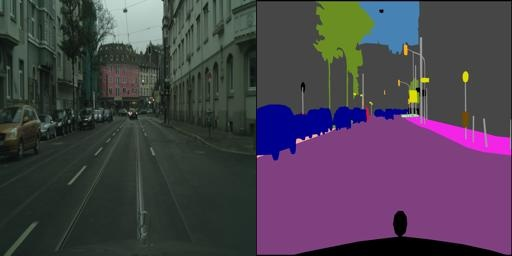

In [51]:
Image.open("../data/Cityscapes/cityscapes_data/train/1000.jpg")

<div class="alert alert-success">

В одной картинки содержится обычная фотография и маска 👺 Поэтому нам придется их разделить

# <center> 🍡 Собираем базовый pipeline! </center>

<div class="alert alert-info">

Определим алгоритм работы нашего `Dataset'a`:
* Разделим картинку на две - `img`, `mask`
* Отнормируем `img`
* Закодируем `mask` в классы для корректной работы loss'а

Алгоритм ясен - давайте писать код!


In [52]:
# Словарь, в котором зашифрована color-map
idx_to_name = [
    "unlabeled",
    "ego vehicle",
    "rectification border",
    "out of roi",
    "static",
    "dynamic",
    "ground",
    "road",
    "sidewalk",
    "parking",
    "rail track",
    "building",
    "wall",
    "fence",
    "guard rail",
    "bridge",
    "tunnel",
    "pole",
    "polegroup",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "caravan",
    "trailer",
    "train",
    "motorcycle",
    "bicycle",
    "license plate",
]

idx_to_category = [
    "void",
    "flat",
    "construction",
    "object",
    "nature",
    "sky",
    "human",
    "vehicle",
]

# Colormap, если хотите правильно отрисовать картинки
idx_to_color = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [111, 74, 0],
    [81, 0, 81],
    [128, 64, 128],
    [244, 35, 232],
    [250, 170, 160],
    [230, 150, 140],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [180, 165, 180],
    [150, 100, 100],
    [150, 120, 90],
    [153, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 0, 90],
    [0, 0, 110],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    [0, 0, 142],
]

idx_to_color_np = np.array(idx_to_color)

name_to_category = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 2,
    12: 2,
    13: 2,
    14: 2,
    15: 2,
    16: 2,
    17: 3,
    18: 3,
    19: 3,
    20: 3,
    21: 4,
    22: 4,
    23: 5,
    24: 6,
    25: 6,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7,
    31: 7,
    32: 7,
    33: 7,
    34: 7,
}

In [53]:
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)


# Преобразуем картинку:
# - расклеим картинки
# - восстановим классы из масок
def preprocess_image(path: str, sparse_mapping=True):
    img = Image.open(path)
    width, height = img.size

    img = np.asarray(img)
    raw, mask = img[:, : width // 2, :], img[:, width // 2 :, :]

    height, width, channels = mask.shape

    distances = np.sum(
        (mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np) ** 2, axis=2
    )
    classes = np.argmin(distances, axis=1).reshape(height, width)

    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)

    return raw, mask, classes

<div class="alert alert-info">

Базовый датасет выглядит довольно просто 🏋️‍♀️

In [54]:
class CityScapesDataset(Dataset):
    def __init__(self, cfg, split="train"):
        self.cfg = cfg

        self.folder_path = self.cfg.folder_path / split
        self.data_list = sorted(list(self.folder_path.glob("*.jpg")))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        raw_image, _, classes = preprocess_image(self.data_list[idx])
        image = (raw_image / 255).transpose((2, 0, 1))

        image = torch.Tensor(image)
        mask = torch.Tensor(classes)

        return image, mask

<div class="alert alert-info">

Пишем любимый `DataModule` 🤗

In [55]:
from lightning import LightningDataModule


class CityScapesDatamodule(LightningDataModule):
    def __init__(self, cfg: CFG) -> None:
        super().__init__()

        self.cfg = cfg
        self.batch_size = self.cfg.batch_size

    def setup(self, stage: str):
        # Создаем Dataset'ы
        self.dataset_train = CityScapesDataset(self.cfg, "train")
        self.dataset_valid = CityScapesDataset(self.cfg, "val")

    def _make_dataloader(self, dataset, cfg):
        # Общий метод для создания DataLoader
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.cfg.num_workers,
            # pin_memory=True,
        )

    def train_dataloader(self):
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.dataset_train, cfg)

    def val_dataloader(self):
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.dataset_valid, cfg)

<div class="alert alert-info">

Посмотрим на картинку вместе с маской 🎭

In [57]:
dm = CityScapesDatamodule(cfg)
dm.prepare_data()
dm.setup(stage="fit")

In [58]:
dl = iter(dm.train_dataloader())
sample = next(dl)

In [59]:
images, masks = sample
image, mask = images[0], masks[0]

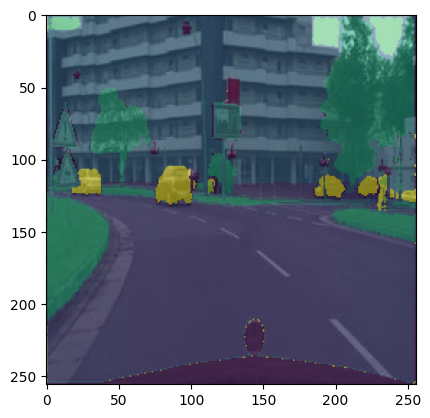

In [60]:
plt.imshow(image.permute(1, 2, 0))
plt.imshow(mask, alpha=0.5)

<div class="alert alert-success">

С датасетом разобрались, теперь можем переходить к обучению нашей модели 🦾

# <center> ⚡️ Предобученная модель + Данные = Transfer learning <center>

<div class="alert alert-info">

Чаще всего приходится обучать модель не с нуля, а какими-либо способами **дообучать** ее на своих данных. Так и поступим 😊

Возьмем предобученный [UNet](https://paperswithcode.com/method/u-net) из удобной библиотеки [SMP](https://github.com/qubvel-org/segmentation_models.pytorch). Модель не слишком большая, поэтому будем учить все слои модели

In [61]:
import torchmetrics as tm

# Возьмём набор метрик характерных для сегментации
train_metrics = tm.MetricCollection(
    tm.JaccardIndex(task="multiclass", num_classes=cfg.n_classes),
    # tm.Dice(num_classes=cfg.n_classes),
    tm.F1Score(task="multiclass", num_classes=cfg.n_classes),
    prefix="train/",
)

valid_metrics = tm.MetricCollection(
    tm.JaccardIndex(task="multiclass", num_classes=cfg.n_classes),
    # tm.Dice(num_classes=cfg.n_classes),
    tm.F1Score(task="multiclass", num_classes=cfg.n_classes),
    prefix="valid/",
)

In [62]:
class ScapedModel(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # Создаем backbone модель с заданной архитектурой и параметрами
        self.model = smp.create_model(
            self.cfg.arch,  # Архитектура модели
            encoder_name=self.cfg.enc_name,  # Имя энкодера
            encoder_weights="imagenet",  # Веса энкодера
            in_channels=3,  # Количество входных каналов (RGB)
            classes=self.cfg.n_classes,  # Количество классов для классификации
            activation=None,  # Активация на выходе
        )

        self.loss_fn = (
            nn.CrossEntropyLoss()
        )  # Функция потерь для многоклассовой классификации

        self.train_metrics = train_metrics  # Метрики для обучения
        self.valid_metrics = valid_metrics  # Метрики для валидации

        self.softmax = nn.Softmax(dim=1)  # Softmax для получения вероятностей классов

    def forward(self, x):
        return self.model(x)  # Прямой проход через модель

    def basic_step(self, batch, stage):
        images, masks = batch  # Извлекаем изображения и маски из батча
        out = self.forward(images)  # Получаем выход модели

        # Определяем метрики в зависимости от стадии (обучение или валидация)
        match stage:
            case "train":
                metrics = self.train_metrics
            case "valid":
                metrics = self.valid_metrics
            case _:
                metrics = self.train_metrics

        y_prob = out.softmax(
            dim=1
        )  # Применяем softmax для получения вероятностей классов

        metrics.update(y_prob, masks.long())  # Обновляем метрики
        calculated_metrics = metrics.compute()  # Вычисляем метрики
        loss = self.loss_fn(y_prob, masks.long())  # Вычисляем значение функции потерь
        calculated_metrics[f"{stage}/CrossEntropyLoss"] = (
            loss  # Добавляем потери в метрики
        )

        self.log_dict(
            calculated_metrics, prog_bar=True
        )  # Логируем метрики для отображения в прогресс-баре

        return calculated_metrics  # Возвращаем вычисленные метрики

    def training_step(self, batch, batch_idx):
        return self.basic_step(batch, "train")["train/CrossEntropyLoss"]  # Шаг обучения

    def validation_step(self, batch, batch_idx):
        return self.basic_step(batch, "valid")[
            "valid/CrossEntropyLoss"
        ]  # Шаг валидации

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.cfg.lr
        )  # Создаем оптимизатор
        return [optimizer]  # Возвращаем список оптимизаторов

<div class="alert alert-info">

**Обратите внимание: 🥸** Класс нейронной сети практически не изменился!
<br>
Мы поменяли только основную модель, а функции для обучения остались такими же - удобство `Lightning` 🥳

# <center> Переходим к обучению через `Trainer` 💪

In [63]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [64]:
trainer = Trainer(
    accelerator="gpu",  # Где обучаем нейронку
    devices=cfg.device_count,  # Если несколько GPU, TPU
    fast_dev_run=True,  # Отладочный запуск крайне важен!
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

trainer.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBL

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassJaccardIndex', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassF1Score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/CrossEntropyLoss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
`Trainer.fit` stopped: `max_steps=1` reached.


In [65]:
# Освободим на всякий случай место на GPU
del model, dm

In [66]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [67]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.strategies import DDPStrategy

trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### <center> 🧠 Посмотрим на затрачиваемые ресурсы - память, время ⏳

In [68]:
%%time
trainer.fit(model, datamodule=dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/user/models/unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassJaccardIndex', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassF1Score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/CrossEntropyLoss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


CPU times: user 435 ms, sys: 456 ms, total: 891 ms
Wall time: 1min 56s


<div class="alert alert-success">

Время обучения - **1 минута 56 секунд**
<br>
Потребление памяти - **11.41 * 4 = 45.64gb**

Позже посмотрим, как можно ускорить обучение и сэкономить память вашей видеокарты 😏

### <center> Видит ли модель машины? 🧐

In [69]:
outs = model(images)
y_pred = outs.argmax(dim=1)

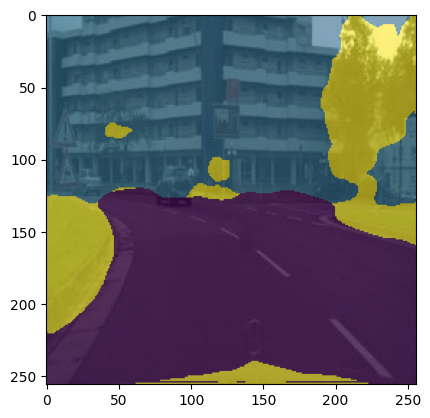

In [70]:
plt.imshow(images[0].permute((1, 2, 0)))
plt.imshow(y_pred[0], alpha=0.6)

In [71]:
del model, dm
torch.cuda.empty_cache()

<div class="alert alert-success" style="display: flex; justify-content: space-between; align-items: center;">

<div style="text-align:left">

Собрав базовый Pipeline, можем переходить к продвинутым фишкам `Lightning` 😎
</div>

<img src="https://i.imgur.com/1UFn5ew.gif" align="right"> 

<div class="alert alert-info">

Фишек очень много, поэтому рассмотрим их по блокам:

- Лайфхаки при обучении сетки
- Быстрый инференс на CPU, GPU
- Мельком посмотрим на то, как запускать модель в API

## <center> Фишки, связанные с обучением сетки 🌐

### <center> 🎁 Компиляция модели

<div class="alert alert-info">

Для чего нужна компиляция модели? 🤨
- **Ускорение вычислений**: Компиляция преобразует ваш код в оптимизированные низкоуровневые операции, что особенно полезно для больших моделей и данных.
- **Аппаратная оптимизация**: Использует возможности `GPU/TPU` эффективнее (например, `fused kernels` для матричных операций).


<div class="alert alert-info">

Заметная разница будет на кластере с 8+ GPU и если видеокарты новые от поколения `Ampere`. У нас таких мощностей нет, но рассмотреть стоит! 🤗

In [80]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [81]:
# Компилируем нашу модель
model_compiled = torch.compile(model)

In [82]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [79]:
# %%time
# trainer.fit(model_compiled, dm)

In [ ]:
del model, dm

In [ ]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
)

In [ ]:
# %%time
# trainer.fit(model, dm)

In [ ]:
del model, dm

## <center> 🎲 N-bit Precision

<div class="alert alert-info">

`N-bit Precision` — это использование весов с пониженной битностью (меньше 32 бит) для ускорения вычислений и сокращения потребления памяти. В `Lightning` этот параметр можно настроить через `precision` в `Trainer`.
Основные типы точности:

- **FP32 (32-битная)**:<br>
Стандартный формат для обучения. Высокая точность, но требует много памяти и вычислительных ресурсов.

- **FP16 (16-битная)**:
В 2 раза меньше памяти, ускоряет матричные операции на GPU.
**Риск переполнения/недополнения** (числа вне диапазона ±65,504 теряются)

- **BF16 (Brain Floating Point)**:
    16 бит, но с большим диапазоном, чем FP16 (как у FP32).
    Стабильнее для обучения, но менее точный в дробной части.
    Поддерживается современными GPU (например, NVIDIA A100, TPU).

- **INT8 (8-битная)**:
        Используется для квантования моделей (сжатие после обучения).
        Сильно сокращает размер модели, но требует калибровки данных.
        Чаще применяется на этапе инференса (вывода), а не обучения.


<div class="alert alert-success" align="center">

Мини-схемка о том, как работают разные механизмы `precision` в памяти:

<img src="https://i.imgur.com/Fn33CBd.jpeg" align="center"> </img>

In [83]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [86]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    precision="16-mixed",  # с какой точностью хранятся веса
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [87]:
%%time
trainer.fit(model, dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/user/models/unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassJaccardIndex', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassF1Score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/CrossEntropyLoss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


CPU times: user 395 ms, sys: 484 ms, total: 879 ms
Wall time: 2min 2s


<div class="alert alert-info">
    
Стоит быть осторожным с использованием `precision` в `Trainer`: некоторые типы весов могут быть использованы только на определенных устройствах: <br>

<img src="https://i.imgur.com/mjtQIlT.png" align="center">

## <center> Gradient accumulation 🔋

<div class="alert alert-info">

**Gradient Accumulation** (Накопление градиентов)

**Что это?** 
Техника, позволяющая имитировать большой размер батча при ограниченных ресурсах GPU. Вместо обновления весов после каждого батча, градиенты накапливаются за несколько шагов, и обновление происходит только после нескольких итераций

<div class="alert alert-info">
    
**Зачем нужно?** 
* Экономия памяти GPU: Если большой батч не помещается в память, его можно разбить на мини-батчи.
* Стабильность обучения: Большой эффективный батч дает менее шумные оценки градиента.

`Gradient Accumulation` - можно включить, добавив гиперпараметр `accumulate_grad_batches` в `Trainer`. `accumulate_grad_batches` должен быть >= 1, при значении 1 - накопление будет происходить через 1 шаг.

In [88]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [89]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    accumulate_grad_batches=2,  # Добавляем gradient accumulation
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [90]:
trainer.fit(model, dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/user/models/unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassJaccardIndex', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassF1Score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/CrossEntropyLoss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [91]:
del model, dm
torch.cuda.empty_cache()

## <center>  Gradient clipping ✂️

<div class="alert alert-info">

**Gradient Clipping** (Отсечение градиентов)

**Что это?**  
Техника для предотвращения взрыва градиентов (особенно в `RNN`, `Transformers`). Если норма градиентов превышает заданный порог, они масштабируются, чтобы остаться в допустимых пределах.

<div class="alert alert-info">

**Зачем нужно?**
* Стабилизация обучения: Защищает от резкого изменения весов.
* Защита от `NaN`: Предотвращает числовую нестабильность.

In [92]:
model = ScapedModel(cfg)
dm = CityScapesDatamodule(cfg)

In [95]:
trainer = Trainer(
    accelerator="gpu",
    devices=cfg.device_count,
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
    accumulate_grad_batches=0.5,  # Добавляем gradient clipping
    callbacks=[
        EarlyStopping(
            monitor="valid/CrossEntropyLoss",
            verbose=False,
        ),
        ModelCheckpoint(
            monitor="valid/CrossEntropyLoss",
            dirpath=f"../models/{cfg.arch}",
            enable_version_counter=True,
            save_top_k=3,
        ),
    ],
    strategy="ddp_notebook_find_unused_parameters_true",  # 4 видеокарты - подключаем новую стратегию
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [96]:
trainer.fit(model, dm)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/user/models/unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassJaccardIndex', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/MulticlassF1Score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/project/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid/CrossEntropyLoss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## <center> Фишки, связанные с инференсом 🏎

### <center> ONNX 🔥

<div class="alert alert-info">

`ONNX` (Open Neural Network Exchange) — открытый формат для представления моделей,позволяет конвертировать модели между фреймворками (`PyTorch`, `JAX`, `TensorFlow`, и др.) и выполнять их запуск в других библиотеках

<div class="alert alert-info">

**Когда применять `ONNX`?**

- **Развертывание моделей на прод:**
    Часто бывает, что запуском моделей занимаются другие люди, поэтому удобно иметь единый интерфейс с запуском ваших моделей. Также запуск модельки на других языках - больше не проблема, так как `ONNX` портирован на большинство популярных языков: `C++`, `Java`, `C#` и др.
- **Оптимизация производительности:**
    Использование `ONNX Runtime` может значительно ускорить inference модели на `CPU`, что очень удобно для высоконагруженных сервисов

In [97]:
# Сохраним нашу модель в ONNX, вызвав один метод to_onnx

input_sample = torch.randn(
    (1, 3, 256, 256)
)  # Сгенерируем рандомный sample. Главное, чтобы совподали размерности!

model.to_onnx(
    f"../models/{cfg.arch}/model.onnx",  # Путь до модели
    input_sample,  # Входной сигнал
    export_params=True,  # Сохраним веса в тот же файлик
)

/home/user/project/.venv/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:309: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/user/project/.venv/lib/python3.10/site-packages/torch/onnx/utils.py:691: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/user/project/.venv/lib/python3.10/site-packages/torch/onnx/utils.py:1161: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx

<div class="alert alert-warning">

<p style="text-align:center">
Обязательно проверяйте модель 👺
</p>

Прежде чем передать модель на следующий этап - проверьте запускается ли она. Чем решать 10 проблем с запуском модели на проде, лучше 1 раз проверить их локально 🤫

In [98]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(f"../models/{cfg.arch}/model.onnx")
input_name = ort_session.get_inputs()[0].name

In [99]:
ort_inputs = {input_name: np.random.randn(1, 3, 256, 256).astype(np.float32)}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

[array([[[[-0.10797382, -0.11960144, -0.02662435, ...,  0.19250768,
            0.43134904,  0.36250296],
          [-0.40942395, -0.60971147, -0.6007372 , ..., -0.02632659,
            0.38418123,  0.27764058],
          [-0.70013046, -1.0555363 , -1.1046215 , ..., -0.39338467,
            0.1881977 ,  0.21858358],
          ...,
          [ 0.21743235,  1.0909764 ,  1.9473237 , ...,  3.5754993 ,
            2.969853  ,  1.6548638 ],
          [ 0.16710614,  0.9273007 ,  1.6151342 , ...,  2.9328222 ,
            2.3236089 ,  1.2923615 ],
          [ 0.34093612,  0.90361255,  1.3035344 , ...,  2.3699298 ,
            2.0404267 ,  1.0928909 ]],
 
         [[-0.9520253 , -1.2627395 , -1.4403099 , ..., -1.4282233 ,
           -0.9737574 , -0.33045447],
          [-0.7747196 , -1.374998  , -1.8751552 , ..., -1.7958053 ,
           -1.3154682 , -0.5385248 ],
          [-0.7003524 , -1.174872  , -1.7327199 , ..., -2.1639585 ,
           -1.6755726 , -0.82126933],
          ...,
          [ 0

## <center> TorchScript 🧨

<div class="alert alert-info">

`TorchScript` - модуль `PyTorch` для сериализации моделей в формат, независимый от Python. Позволяет выполнять модели в средах без Python (C++, мобильные устройства) через `JIT`-компиляцию. 

Поддерживает два режима: 
* `tracing` (запись графа через пример данных)
* `scripting` (явное описание логики с сохранением динамики).

<div class="alert alert-info">

**Принципиальные отличия от `ONNX`**
- **Цель использования:**
    `TorchScript` — оптимизация и деплой моделей ТОЛЬКО `PyTorch`. Поэтому и ее запуск предполагает использование `PyTorch`.
    В то же время `ONNX` — стандарт, который поддерживает обучение модели на `PyTorch`, а ее запуск на `TensorFlow.js`

- **Гибкость графа вычислений:**
    `TorchScript` лучше сохраняет динамические операции (условия, циклы) через режим `scripting`.
    `ONNX`лучше работает на статических графах, но в современных версиях (после 15) стали поддерживать динамические операции

In [104]:
# Сохраним нашу модель в ONNX, вызвав один метод to_torchscript
torch.jit.save(  # Сохраняем многопоточно
    model.to_torchscript(
        file_path=f"../models/{cfg.arch}/model.pt",
        method="trace",
        example_inputs=torch.randn(1, 3, 256, 256),
    ),
    f"../models/{cfg.arch}/model.pt",
)

<div class="alert alert-warning">

Опять же - проверяем модель!

In [106]:
inp = torch.rand(1, 3, 256, 256)
scripted_module = torch.jit.load(f"../models/{cfg.arch}/model.pt")
output = scripted_module(inp)
output

tensor([[[[ 0.0447,  0.1643,  0.1819,  ...,  0.1714,  0.1583,  0.1159],
          [-0.0351, -0.0703, -0.0549,  ...,  0.0480,  0.1503,  0.0452],
          [-0.3100, -0.4660, -0.5374,  ..., -0.0712,  0.0757,  0.0447],
          ...,
          [ 1.4918,  3.1804,  4.2266,  ...,  4.5520,  3.6541,  2.1000],
          [ 1.1431,  2.8351,  3.7974,  ...,  4.0287,  3.2033,  1.8967],
          [ 1.0855,  2.3484,  2.9978,  ...,  3.2617,  2.7330,  1.5188]],

         [[-0.7182, -0.8370, -1.1823,  ...,  0.0944,  0.3971,  0.3377],
          [-0.6847, -0.9938, -1.3078,  ...,  0.1596,  0.3545,  0.3169],
          [-0.5303, -0.8293, -1.2716,  ...,  0.6281,  0.6735,  0.3948],
          ...,
          [ 0.9388,  1.3703,  1.5705,  ...,  1.3171,  1.0645,  0.5252],
          [ 0.0679,  0.1977,  0.3852,  ...,  0.3923,  0.5525,  0.3819],
          [-0.0516, -0.2565, -0.2997,  ..., -0.2766, -0.1748, -0.0599]],

         [[ 1.0072,  1.8160,  2.0958,  ...,  0.7825,  0.8922,  0.3418],
          [ 1.7500,  3.3375,  

# <center> 🧸 Выводы и заключения ✅

<div class="alert alert-success">
    
**В этом уроке:**
- Изучили продвинутые фишки `Lightning` для тренировки моделей, теперь легко сможете контролировать процесс обучения в зависимости от доступных ресурсов.
- Узнали какие есть фишки в `Lightning` для ускорения инференса моделей, и простого переезда обученной модели на другие фреймворки, среды исполнения, ресурсы.

<div class="alert alert-info">
    
- И для всех этих действий понадобится добавить один гиперпараметр в обучение или пару строк кода!
- Для эффективного обучения модели есть `precision`, `gradient accumulation`, `gradient clipping`
- Для ускорения инференса модели есть `torchscipt`, `ONNX`
- Точек для оптимизации модели много, поэтому стоит использовать уже готовые решения, как `Lightning`, а не изобретать 🚲